<a href="https://colab.research.google.com/github/isabellacadisco/text-data-for-trading-/blob/main/Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploiting the series itself

In [ ]:
# *IMPORT LIBRARIES USED*

!pip install prophet
!pip install yfinance

from prophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download data

In [ ]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

In [ ]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

In [ ]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-01,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473
2010-01-04,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492
2010-01-05,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826
2010-01-06,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471
2010-01-07,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768
...,...,...,...,...,...,...,...
2023-06-07,1.069805,1.242854,0.90713,139.526993,149.255997,1.33986,0.667909
2023-06-08,1.070744,1.244586,0.90954,139.899002,149.787994,1.33716,0.665860
2023-06-09,1.078272,1.255950,0.89870,138.863007,149.720001,1.33620,0.671260


## Data exploration

check missing values

In [ ]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2011-04-15,1.443210,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-27,1.309278,1.568209,NaN,77.459999,101.421997,1.0024,1.061582
2012-01-31,1.313957,1.570845,NaN,76.360001,100.330002,1.0024,1.058604
2012-12-04,NaN,1.609787,NaN,82.133003,107.301003,NaN,NaN
2013-10-08,NaN,NaN,NaN,NaN,131.289993,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,123.438004,NaN,NaN


In [ ]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,


In [ ]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3506 entries, 2010-01-01 to 2023-06-13
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3506 non-null   float64
 1   gbpusd_close  3506 non-null   float64
 2   usdchf_close  3506 non-null   float64
 3   usdjpy_close  3506 non-null   float64
 4   eurjpy_close  3506 non-null   float64
 5   usdcad_close  3506 non-null   float64
 6   audusd_close  3506 non-null   float64
dtypes: float64(7)
memory usage: 219.1 KB


In [ ]:
forex_df.describe()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
count,3506.000000,3506.000000,3506.000000,3506.000000,3506.000000,3506.000000,3506.000000
mean,1.202636,1.426408,0.954046,105.605341,125.544652,1.202985,0.818408
std,0.113950,0.151549,0.049953,15.770212,11.677510,0.140232,0.129423
min,0.959619,1.072754,0.722800,75.739998,94.209999,0.943200,0.574290
25%,1.113093,1.294498,0.919442,97.393751,118.220999,1.039357,0.717566
50%,1.176851,1.400845,0.956375,108.261997,127.092999,1.264245,0.765462
75%,1.306165,1.567024,0.986900,113.399000,133.297249,1.319090,0.927902
max,1.484406,1.716090,1.162700,150.175995,151.048996,1.457800,1.103497


## Visualize data

In [ ]:
for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

## Forecast exploiting series from 2010

In [ ]:
forex_df

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close
Date,,,,,,,
2010-01-01,1.438994,1.613294,1.03390,92.919998,133.710007,1.05120,0.898473
2010-01-04,1.442398,1.611370,1.02910,92.495003,133.389999,1.04100,0.912492
2010-01-05,1.436596,1.599079,1.03370,91.584999,131.529999,1.03950,0.911826
2010-01-06,1.440403,1.602384,1.02760,92.356003,133.013000,1.03190,0.920471
2010-01-07,1.431803,1.593397,1.03360,93.389999,133.748001,1.03400,0.917768
...,...,...,...,...,...,...,...
2023-06-07,1.069805,1.242854,0.90713,139.526993,149.255997,1.33986,0.667909
2023-06-08,1.070744,1.244586,0.90954,139.899002,149.787994,1.33716,0.665860
2023-06-09,1.078272,1.255950,0.89870,138.863007,149.720001,1.33620,0.671260


In [ ]:
# In order to forecast the series we need to: 1.
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

,eurusd_close,gbpusd_close,usdchf_close,usdjpy_close,eurjpy_close,usdcad_close,audusd_close,ds,y
Date,,,,,,,,,
2023-06-07,1.069805,1.242854,0.90713,139.526993,149.255997,1.33986,0.667909,2023-06-07,1.069805
2023-06-08,1.070744,1.244586,0.90954,139.899002,149.787994,1.33716,0.665860,2023-06-08,1.070744
2023-06-09,1.078272,1.255950,0.89870,138.863007,149.720001,1.33620,0.671260,2023-06-09,1.078272
2023-06-12,1.075095,1.258099,0.90320,139.371002,149.820007,1.33368,0.674500,2023-06-12,1.075095
2023-06-13,1.076299,1.251533,0.90830,139.460007,150.091003,1.33630,0.675310,2023-06-13,1.076299


In [ ]:
# consider just EURUSD
EURUSD_data = forex_df[['ds','y']].copy()

In [ ]:
EURUSD_data

,ds,y
Date,,
2010-01-01,2010-01-01,1.438994
2010-01-04,2010-01-04,1.442398
2010-01-05,2010-01-05,1.436596
2010-01-06,2010-01-06,1.440403
2010-01-07,2010-01-07,1.431803
...,...,...
2023-06-07,2023-06-07,1.069805
2023-06-08,2023-06-08,1.070744
2023-06-09,2023-06-09,1.078272


In [ ]:
from prophet.diagnostics import cross_validation

In [ ]:
m = Prophet()

In [ ]:
m.fit(EURUSD_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/519rdfm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/q0oflui2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55615', 'data', 'file=/tmp/tmp_na5duox/519rdfm9.json', 'init=/tmp/tmp_na5duox/q0oflui2.json', 'output', 'file=/tmp/tmp_na5duox/prophet_modelncz4xtkz/prophet_model-20230614145518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon = '5 days')


INFO:prophet:Making 140 forecasts with cutoffs between 2012-01-07 00:00:00 and 2023-06-08 00:00:00


  0%|          | 0/140 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/_88g30t0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/25bt446s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15822', 'data', 'file=/tmp/tmp_na5duox/_88g30t0.json', 'init=/tmp/tmp_na5duox/25bt446s.json', 'output', 'file=/tmp/tmp_na5duox/prophet_model93zz5xzj/prophet_model-20230614150510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/fjik7wok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/dpltg8rz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:

df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-01-09,1.308991,1.290316,1.328324,1.268038,2012-01-07
1,2012-01-10,1.308690,1.291166,1.328048,1.277596,2012-01-07
2,2012-01-11,1.311046,1.293130,1.330382,1.275185,2012-01-07
3,2012-01-12,1.313168,1.294059,1.332755,1.272394,2012-01-07
4,2012-02-07,1.303991,1.283722,1.325194,1.312164,2012-02-06


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
#df_cv.head()

In [ ]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.002286,0.047810,0.037986,0.033368,0.028614,0.033154,0.370000
1,2 days,0.002329,0.048258,0.038155,0.033453,0.027114,0.033175,0.393939
2,3 days,0.002298,0.047937,0.038735,0.033849,0.029536,0.033620,0.400000
3,4 days,0.002237,0.047296,0.039338,0.034244,0.030438,0.034097,0.310000
4,5 days,0.002539,0.050387,0.042133,0.036760,0.034270,0.036551,0.310000


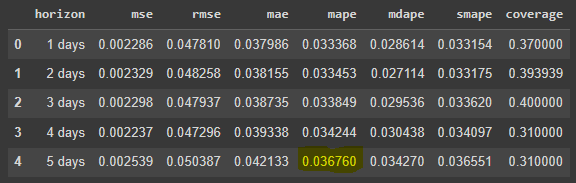

## Forecast exploiting series from 2018

In [ ]:
EURUSD_data

,ds,y
Date,,
2010-01-01,2010-01-01,1.438994
2010-01-04,2010-01-04,1.442398
2010-01-05,2010-01-05,1.436596
2010-01-06,2010-01-06,1.440403
2010-01-07,2010-01-07,1.431803
...,...,...
2023-06-07,2023-06-07,1.069805
2023-06-08,2023-06-08,1.070744
2023-06-09,2023-06-09,1.078272


In [ ]:
EURUSD_data_2018 = EURUSD_data[EURUSD_data['ds']>'2018-01-01']

In [ ]:
EURUSD_data_2018

,ds,y
Date,,
2018-01-02,2018-01-02,1.201158
2018-01-03,2018-01-03,1.206345
2018-01-04,2018-01-04,1.201043
2018-01-05,2018-01-05,1.206884
2018-01-08,2018-01-08,1.203746
...,...,...
2023-06-07,2023-06-07,1.069805
2023-06-08,2023-06-08,1.070744
2023-06-09,2023-06-09,1.078272


In [ ]:
m_2018 = Prophet()

In [ ]:
m_2018.fit(EURUSD_data_2018)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/9euhf9y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/eifcz1my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16926', 'data', 'file=/tmp/tmp_na5duox/9euhf9y9.json', 'init=/tmp/tmp_na5duox/eifcz1my.json', 'output', 'file=/tmp/tmp_na5duox/prophet_modelyqmcbcvi/prophet_model-20230614152845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:28:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:28:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv_2018 = cross_validation(m_2018, initial='730 days', period='30 days', horizon = '5 days')


INFO:prophet:Making 42 forecasts with cutoffs between 2020-01-25 00:00:00 and 2023-06-08 00:00:00


  0%|          | 0/42 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/hc6rq6mo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/j3p8mim8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68343', 'data', 'file=/tmp/tmp_na5duox/hc6rq6mo.json', 'init=/tmp/tmp_na5duox/j3p8mim8.json', 'output', 'file=/tmp/tmp_na5duox/prophet_model1p12teew/prophet_model-20230614152947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/rasqolcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/3kjbbw15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_p_2018 = performance_metrics(df_cv_2018)
#df_cv.head()

In [ ]:
df_p_2018

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.000306,0.017494,0.013951,0.012646,0.010603,0.012692,0.466667
1,2 days,0.000302,0.017389,0.014774,0.013317,0.012710,0.013333,0.366667
2,3 days,0.000302,0.017383,0.014231,0.012736,0.011957,0.012755,0.366667
3,4 days,0.000474,0.021765,0.015717,0.014164,0.010381,0.014293,0.500000
4,5 days,0.000512,0.022635,0.016996,0.015361,0.011123,0.015490,0.366667


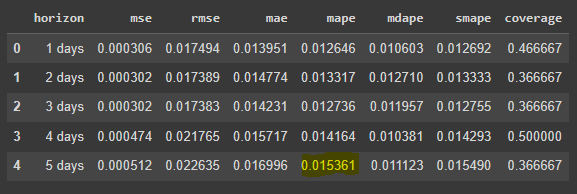

Since the performance is improved we will use the series from 2018 for all the three tasks

# Series itself + external regressors

In [ ]:
# download external regressors
def get_new_data():
    url_extra = 'https://drive.google.com/file/d/1CT91MvzT2-WLK6rTdDu4-vBdj0kyfDP5/view?usp=sharing'
    url_covid = 'https://drive.google.com/file/d/1ZlwZtSdtxlTlP2RUZtYjqpVSiaXMEzXO/view?usp=sharing'



    file_id = url_extra.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_extra = pd.read_csv(dwn_url, parse_dates=['DATE'])



    file_id = url_covid.split('/')[-2]
    dwn_url = 'https://drive.google.com/uc?id=' + file_id
    df_covid = pd.read_csv(dwn_url, parse_dates=['date'])



    return df_extra, df_covid

In [ ]:
extra_df, df_covid = get_new_data()

In [ ]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})

Create "5 days before date column for time series"

In [ ]:
EURUSD_data_2018['five_days_before'] = EURUSD_data_2018['ds'] - pd.to_timedelta(5, unit='D')

<ipython-input-54-ac0ffcd815a7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
EURUSD_data_2018

,ds,y,five_days_before
Date,,,
2018-01-02,2018-01-02,1.201158,2017-12-28
2018-01-03,2018-01-03,1.206345,2017-12-29
2018-01-04,2018-01-04,1.201043,2017-12-30
2018-01-05,2018-01-05,1.206884,2017-12-31
2018-01-08,2018-01-08,1.203746,2018-01-03
...,...,...,...
2023-06-07,2023-06-07,1.069805,2023-06-02
2023-06-08,2023-06-08,1.070744,2023-06-03
2023-06-09,2023-06-09,1.078272,2023-06-04


In [ ]:
# merge extra regressor 5 weeks before

EURUSD_data_reg_2018 = EURUSD_data_2018.merge(extra_df, left_on='five_days_before', right_index=True, how='left')

EURUSD_data_reg_2018 = EURUSD_data_reg_2018.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_on='five_days_before', right_index=True, how='left')
EURUSD_data_reg_2018 = EURUSD_data_reg_2018.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_on='five_days_before', right_index=True, how='left')
EURUSD_data_reg_2018['covid_US'] = EURUSD_data_reg_2018['covid_US'].fillna(0)
EURUSD_data_reg_2018['covid_EU'] = EURUSD_data_reg_2018['covid_EU'].fillna(0)

In [ ]:
EURUSD_data_reg_2018

,ds,y,five_days_before,consumer_price_index,GDP_US,inflation,covid_US,covid_EU
Date,,,,,,,,
2018-01-02,2018-01-02,1.201158,2017-12-28,247.736,19937.963,1.96,0.0,0.0
2018-01-03,2018-01-03,1.206345,2017-12-29,247.736,19937.963,1.96,0.0,0.0
2018-01-04,2018-01-04,1.201043,2017-12-30,247.736,19937.963,1.96,0.0,0.0
2018-01-05,2018-01-05,1.206884,2017-12-31,247.736,19937.963,1.96,0.0,0.0
2018-01-08,2018-01-08,1.203746,2018-01-03,248.721,20242.215,1.98,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-06-07,2023-06-07,1.069805,2023-06-02,NaN,NaN,NaN,0.0,0.0
2023-06-08,2023-06-08,1.070744,2023-06-03,NaN,NaN,NaN,0.0,0.0
2023-06-09,2023-06-09,1.078272,2023-06-04,NaN,NaN,NaN,0.0,0.0


<ipython-input-59-09718cbe497d>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

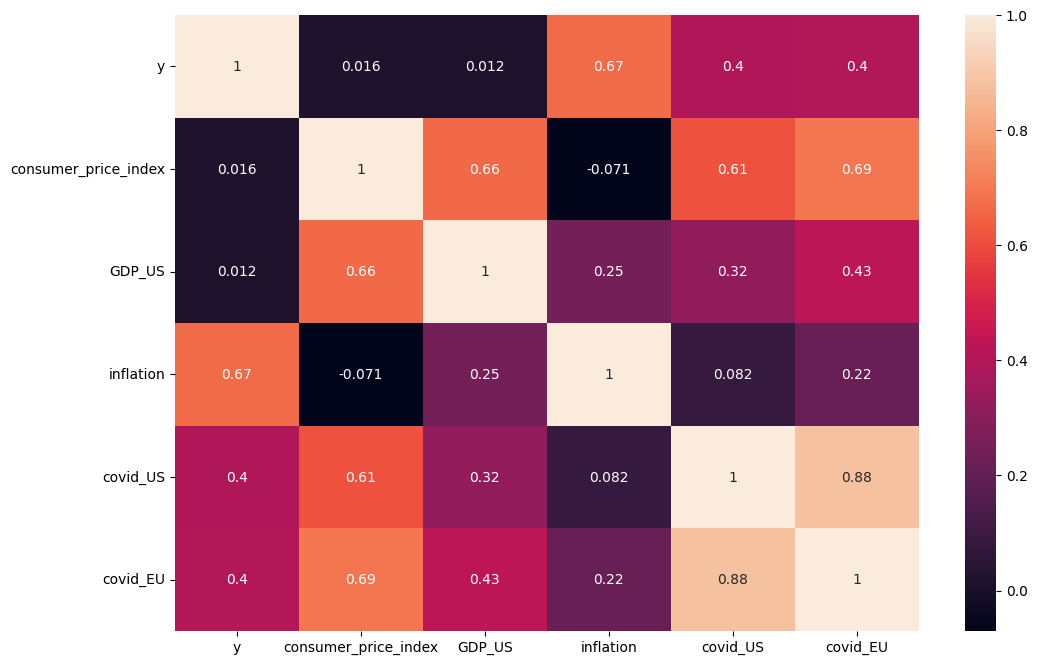

In [ ]:
# explore correlation with extra regressors two weeks before
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(EURUSD_data_reg_2018.corr(), annot=True, ax=ax)

In [ ]:
# define Prophet model with hyperparameters
m_reg = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m_reg.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_reg.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['consumer_price_index','GDP_US','inflation', 'covid_US', 'covid_EU']
for reg in extra_regressor:
  m_reg.add_regressor(name=reg, mode='additive')

In [ ]:
EURUSD_data_reg_2018 = EURUSD_data_reg_2018.dropna()

In [ ]:
m_reg.fit(EURUSD_data_reg_2018)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/90xvskh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/630a_fb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38900', 'data', 'file=/tmp/tmp_na5duox/90xvskh8.json', 'init=/tmp/tmp_na5duox/630a_fb2.json', 'output', 'file=/tmp/tmp_na5duox/prophet_model8z7qyp33/prophet_model-20230614154958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv_reg = cross_validation(m_reg, initial='730 days', period='30 days', horizon = '5 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2020-01-26 00:00:00 and 2021-05-20 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/v0t940rw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/msd6qyiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9382', 'data', 'file=/tmp/tmp_na5duox/v0t940rw.json', 'init=/tmp/tmp_na5duox/msd6qyiq.json', 'output', 'file=/tmp/tmp_na5duox/prophet_modelu0exs48w/prophet_model-20230614155040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:50:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:50:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/dkpt7vjn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/f956qvdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
df_p_reg = performance_metrics(df_cv_reg)
#df_cv.head()
df_p_reg

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.000247,0.015702,0.013316,0.011425,0.011496,0.011424,0.384615
1,2 days,0.000302,0.017366,0.014830,0.012833,0.013864,0.012814,0.416667
2,3 days,0.000477,0.021847,0.015882,0.013855,0.009425,0.013945,0.500000
3,4 days,0.000436,0.020870,0.017253,0.014877,0.015070,0.014973,0.333333
4,5 days,0.000366,0.019135,0.017325,0.014909,0.014495,0.014900,0.250000


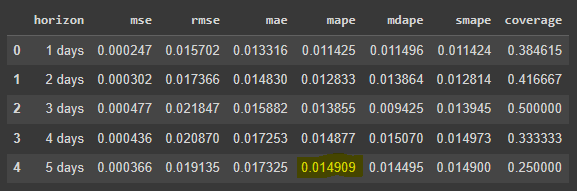

# Series itself + extra regressors + sentiment analysis

In [ ]:
# To read the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sentiment = pd.read_csv('/content/drive/MyDrive/Ammagamma Lab Project/sentiment_extra_reg.csv')

In [ ]:
sentiment

,Unnamed: 0,date,Negative,Neutral,Positive
0,0,2018-01-02,0.982824,0.002747,0.014429
1,1,2018-01-03,0.174240,0.003935,0.821825
2,2,2018-01-05,0.955479,0.003668,0.040853
3,3,2018-01-06,0.985943,0.002905,0.011152
4,4,2018-01-08,0.502520,0.172853,0.324626
...,...,...,...,...,...
1348,1348,2023-11-05,0.617450,0.004003,0.378547
1349,1349,2023-12-01,0.970847,0.002861,0.026292
1350,1350,2023-12-04,0.175564,0.491626,0.332810
1351,1351,2023-12-05,0.508512,0.002792,0.488696


In [ ]:
sentiment = sentiment.drop(sentiment.columns[0], axis=1)

In [ ]:
sentiment

,date,Negative,Neutral,Positive
0,2018-01-02,0.982824,0.002747,0.014429
1,2018-01-03,0.174240,0.003935,0.821825
2,2018-01-05,0.955479,0.003668,0.040853
3,2018-01-06,0.985943,0.002905,0.011152
4,2018-01-08,0.502520,0.172853,0.324626
...,...,...,...,...
1348,2023-11-05,0.617450,0.004003,0.378547
1349,2023-12-01,0.970847,0.002861,0.026292
1350,2023-12-04,0.175564,0.491626,0.332810
1351,2023-12-05,0.508512,0.002792,0.488696


In [ ]:
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [ ]:
sentiment = sentiment.set_index('date')

In [ ]:
sentiment

,Negative,Neutral,Positive
date,,,
2018-01-02,0.982824,0.002747,0.014429
2018-01-03,0.174240,0.003935,0.821825
2018-01-05,0.955479,0.003668,0.040853
2018-01-06,0.985943,0.002905,0.011152
2018-01-08,0.502520,0.172853,0.324626
...,...,...,...
2023-11-05,0.617450,0.004003,0.378547
2023-12-01,0.970847,0.002861,0.026292
2023-12-04,0.175564,0.491626,0.332810


In [ ]:
# merge extra regressor 5 weeks before

EURUSD_data_sent = EURUSD_data_2018.merge(extra_df, left_on='five_days_before', right_index=True, how='left')


EURUSD_data_sent = EURUSD_data_sent.merge(sentiment, left_on='five_days_before', right_index=True, how='left')

EURUSD_data_sent = EURUSD_data_sent.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_on='five_days_before', right_index=True, how='left')
EURUSD_data_sent = EURUSD_data_sent.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_on='five_days_before', right_index=True, how='left')
EURUSD_data_sent['covid_US'] = EURUSD_data_sent['covid_US'].fillna(0)
EURUSD_data_sent['covid_EU'] = EURUSD_data_sent['covid_EU'].fillna(0)

In [ ]:
# merge extra regressor 5 weeks before

data = EURUSD_data_2018.merge(extra_df, left_on='five_days_before', right_index=True, how='left')


data = data.merge(sentiment, left_on='five_days_before', right_index=True, how='left')

data = data.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_on='five_days_before', right_index=True, how='left')
data = data.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_on='five_days_before', right_index=True, how='left')
data['covid_US'] = data['covid_US'].fillna(0)
data['covid_EU'] = data['covid_EU'].fillna(0)

<ipython-input-122-23f02e705bdf>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

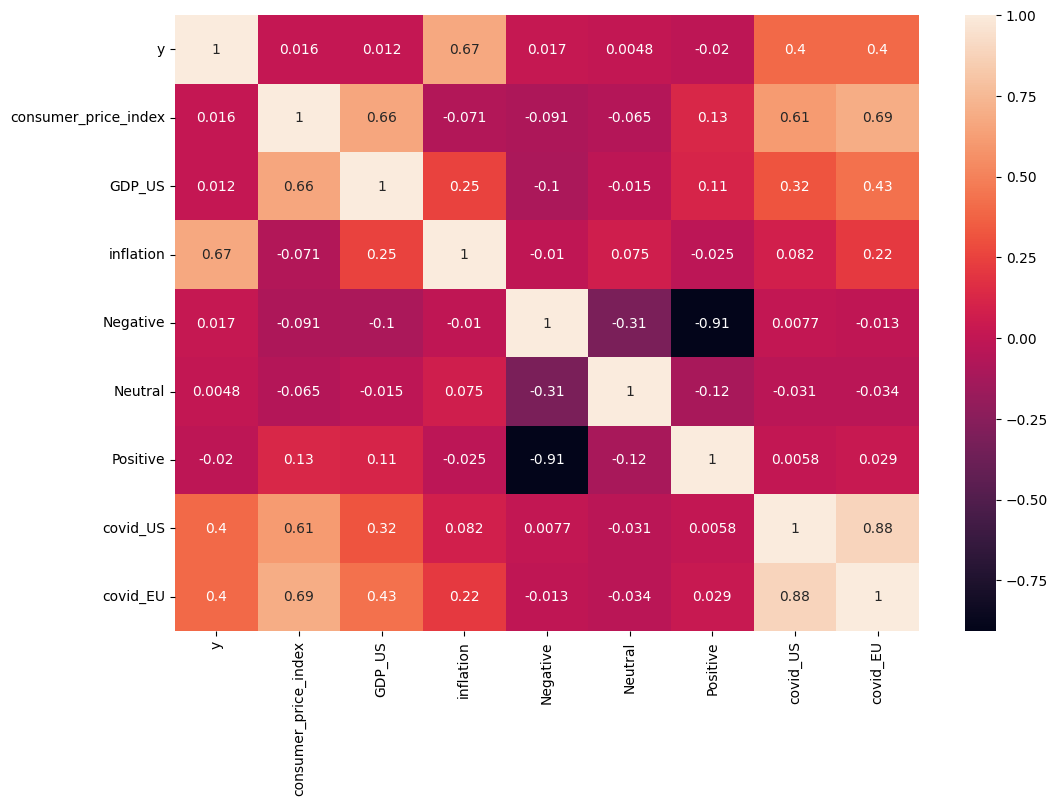

In [ ]:
# explore correlation with extra regressors two weeks before
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(EURUSD_data_sent.corr(), annot=True, ax=ax)

In [ ]:

# define Prophet model with hyperparameters
m_sent = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m_sent.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_sent.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['consumer_price_index','GDP_US','inflation', 'covid_US', 'covid_EU',
                   'Positive', 'Neutral', 'Negative']
for reg in extra_regressor:
  m_sent.add_regressor(name=reg, mode='additive')

In [ ]:
EURUSD_data_sent = EURUSD_data_sent.dropna()

In [ ]:
EURUSD_data_sent

,ds,y,five_days_before,consumer_price_index,GDP_US,inflation,Negative,Neutral,Positive,covid_US,covid_EU
Date,,,,,,,,,,,
2018-01-08,2018-01-08,1.203746,2018-01-03,248.721,20242.215,1.98,0.174240,0.003935,0.821825,0.0,0.0
2018-01-10,2018-01-10,1.192933,2018-01-05,248.721,20242.215,2.01,0.955479,0.003668,0.040853,0.0,0.0
2018-01-11,2018-01-11,1.195614,2018-01-06,248.721,20242.215,2.01,0.985943,0.002905,0.011152,0.0,0.0
2018-01-15,2018-01-15,1.219230,2018-01-10,248.721,20242.215,2.03,0.972137,0.003243,0.024621,0.0,0.0
2018-01-16,2018-01-16,1.226843,2018-01-11,248.721,20242.215,2.00,0.984773,0.002772,0.012455,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-13,2021-05-13,1.207851,2021-05-08,266.832,22048.894,2.49,0.381244,0.441673,0.177083,48282.0,96615.0
2021-05-18,2021-05-18,1.215687,2021-05-13,266.832,22048.894,2.51,0.070794,0.003143,0.926063,54772.0,93044.0
2021-05-19,2021-05-19,1.222400,2021-05-14,266.832,22048.894,2.51,0.982242,0.002899,0.014859,60795.0,89157.0


In [ ]:
m_sent.fit(EURUSD_data_sent)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/hwgpbk2i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/3l9fi8nt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53361', 'data', 'file=/tmp/tmp_na5duox/hwgpbk2i.json', 'init=/tmp/tmp_na5duox/3l9fi8nt.json', 'output', 'file=/tmp/tmp_na5duox/prophet_model7z_8qu6g/prophet_model-20230614162142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv_sent = cross_validation(m_sent, initial='730 days', period='30 days', horizon = '5 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2020-01-26 00:00:00 and 2021-05-20 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/1bq3d0co.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/78vbim9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4457', 'data', 'file=/tmp/tmp_na5duox/1bq3d0co.json', 'init=/tmp/tmp_na5duox/78vbim9o.json', 'output', 'file=/tmp/tmp_na5duox/prophet_modelx493shy7/prophet_model-20230614162200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/h1utnbwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/vzskp9_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:

df_p_sent = performance_metrics(df_cv_sent)
#df_cv.head()
df_p_sent

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.000207,0.014371,0.012042,0.010591,0.010219,0.010601,0.500000
1,2 days,0.000133,0.011529,0.010854,0.009493,0.008633,0.009477,0.571429
2,3 days,0.000202,0.014213,0.011645,0.010045,0.011542,0.010025,0.428571
3,4 days,0.000643,0.025363,0.019947,0.017318,0.009740,0.017558,0.571429
4,5 days,0.000889,0.029812,0.021440,0.018685,0.013093,0.019005,0.428571


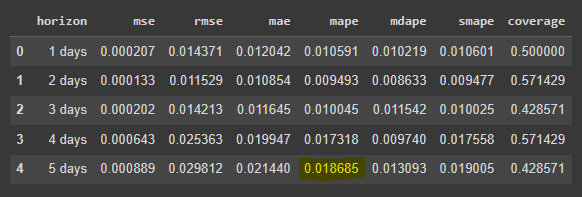


## Forward Fill

In [ ]:
EURUSD_data_sent_FF = data.fillna(method='ffill')

In [ ]:
EURUSD_data_sent_FF

,ds,y,five_days_before,consumer_price_index,GDP_US,inflation,Negative,Neutral,Positive,covid_US,covid_EU
Date,,,,,,,,,,,
2018-01-02,2018-01-02,1.201158,2017-12-28,247.736,19937.963,1.96,NaN,NaN,NaN,0.0,0.0
2018-01-03,2018-01-03,1.206345,2017-12-29,247.736,19937.963,1.96,NaN,NaN,NaN,0.0,0.0
2018-01-04,2018-01-04,1.201043,2017-12-30,247.736,19937.963,1.96,NaN,NaN,NaN,0.0,0.0
2018-01-05,2018-01-05,1.206884,2017-12-31,247.736,19937.963,1.96,NaN,NaN,NaN,0.0,0.0
2018-01-08,2018-01-08,1.203746,2018-01-03,248.721,20242.215,1.98,0.174240,0.003935,0.821825,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07,2023-06-07,1.069805,2023-06-02,266.832,22048.894,2.41,0.961251,0.003780,0.034969,0.0,0.0
2023-06-08,2023-06-08,1.070744,2023-06-03,266.832,22048.894,2.41,0.693071,0.003523,0.303406,0.0,0.0
2023-06-09,2023-06-09,1.078272,2023-06-04,266.832,22048.894,2.41,0.493575,0.492378,0.014047,0.0,0.0


In [ ]:
EURUSD_data_sent_FF = EURUSD_data_sent_FF.dropna()

In [ ]:
# define Prophet model with hyperparameters
m_sent_2 = Prophet(growth='linear',n_changepoints=7, changepoint_prior_scale=0.05)
# add custom seasonality
m_sent_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_sent_2.add_seasonality(name='weekly', period=7, fourier_order=15)
# add extra regressor
extra_regressor = ['consumer_price_index','GDP_US','inflation', 'covid_US', 'covid_EU',
                   'Positive', 'Neutral', 'Negative']
for reg in extra_regressor:
  m_sent_2.add_regressor(name=reg, mode='additive')

In [ ]:
m_sent_2.fit(EURUSD_data_sent_FF)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/ci7c8cmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/5vxytb53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76397', 'data', 'file=/tmp/tmp_na5duox/ci7c8cmr.json', 'init=/tmp/tmp_na5duox/5vxytb53.json', 'output', 'file=/tmp/tmp_na5duox/prophet_modelfgruhcqm/prophet_model-20230614163303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
df_cv_sent_2 = cross_validation(m_sent_2, initial='730 days', period='30 days', horizon = '5 days')

INFO:prophet:Making 42 forecasts with cutoffs between 2020-01-25 00:00:00 and 2023-06-08 00:00:00


  0%|          | 0/42 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/kd_v_7ox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/5agby_nw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49296', 'data', 'file=/tmp/tmp_na5duox/kd_v_7ox.json', 'init=/tmp/tmp_na5duox/5agby_nw.json', 'output', 'file=/tmp/tmp_na5duox/prophet_model3_pi5s_d/prophet_model-20230614163333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/ayx0us2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_na5duox/epqjumfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_p_reg_2 = performance_metrics(df_cv_sent_2)
#df_cv.head()
df_p_reg_2


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.000571,0.023896,0.017803,0.016212,0.013899,0.016375,0.466667
1,2 days,0.000672,0.025914,0.020219,0.018347,0.014643,0.018520,0.366667
2,3 days,0.000684,0.026159,0.020142,0.018134,0.014418,0.018301,0.400000
3,4 days,0.001033,0.032133,0.022084,0.020012,0.011848,0.020374,0.500000
4,5 days,0.000947,0.030774,0.022744,0.020583,0.015312,0.020893,0.333333


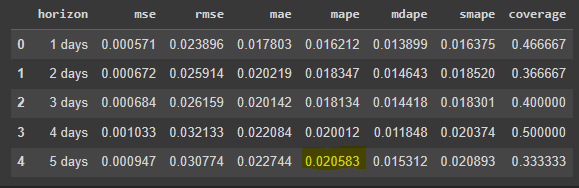